<a href="https://colab.research.google.com/github/sean-otoole/HODD/blob/main/PDTx_pipeline/PDTx_01_DataPrep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scanpy anndata umap-learn python-igraph louvain h5py leidenalg > /dev/null 2>&1

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/MyDrive/HODD/Kamath_et_al_2022")

In [4]:
import scanpy as sc
import pandas as pd
from scipy.io import mmread
import scipy.sparse
# File paths
meta_path = "METADATA_PD.tsv.gz"
matrix_path = "GSE178265_Homo_matrix.mtx.gz"
barcodes_path = "GSE178265_Homo_bcd.tsv.gz"
features_path = "Homo_features.tsv"
# Load sparse count matrix
X = mmread(matrix_path).tocsc()  # Convert to Compressed Sparse Column format for efficiency
# Load barcodes (cell IDs)
barcodes = pd.read_csv(barcodes_path, header=None, sep="\t")[0].values  # Read as a NumPy array
# Load gene names/features
genes = pd.read_csv(features_path, header=None, sep="\t")[0].values  # Read as a NumPy array
# Create AnnData object
adata = sc.AnnData(X.T)
adata.obs_names = barcodes  # Assign cell barcodes
adata.var_names = genes  # Assign gene names
# Load the metadata
metadata_df = pd.read_csv(meta_path, sep="\t")  # Adjust delimiter if needed
metadata_df = metadata_df.drop(metadata_df.index[0])  # Drops unnecessary row
metadata_df = metadata_df.reset_index(drop=True)  # Resets the index values
# Ensure "Name" is the barcode column before setting it as the index
metadata_df = metadata_df.set_index("NAME")
# Reorder metadata to match AnnData object & handle missing barcodes safely
metadata_df = metadata_df.reindex(adata.obs_names)  # Ensures the same order, fills missing barcodes with NaN
# Assign the DataFrame to adata.obs
adata.obs = metadata_df
# Verify
print(adata)

<ipython-input-4-bd624e40e7b5>:21: DtypeWarning: Columns (3,13,14,15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv(meta_path, sep="\t")  # Adjust delimiter if needed


AnnData object with n_obs × n_vars = 434340 × 41625
    obs: 'libname', 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'date', 'Donor_Age', 'Donor_PMI', 'Status', 'Cause_of_Death', 'FACS_Classification'


In [5]:
# subset the data for NR4A2 positive nuclei

adata = adata[adata.obs["FACS_Classification"] == "Positive"].copy()

# Filter the AnnData object for only "normal" and "Parkinson disease"
adata = adata[adata.obs["disease__ontology_label"].isin(["normal", "Parkinson disease"])]

In [6]:
# calculate standard quality control metrics

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

<ipython-input-6-53f747c6a125>:4: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mt"] = adata.var_names.str.startswith("MT-")


In [7]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


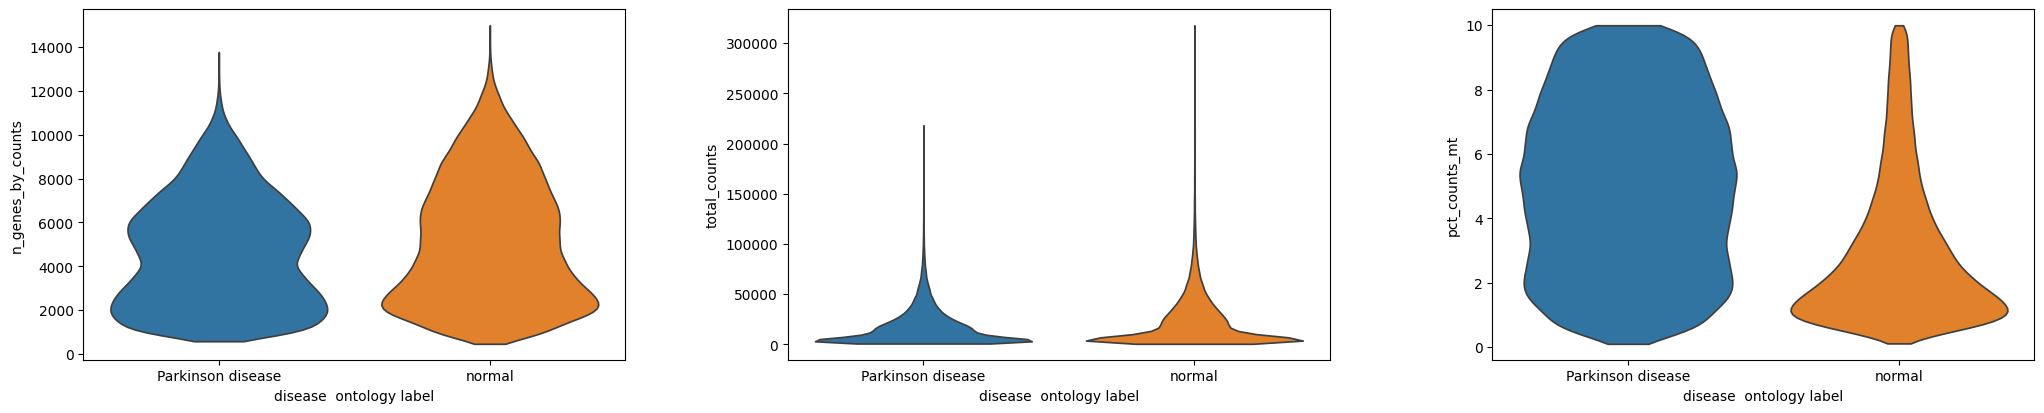

In [8]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    stripplot=False,
    multi_panel=True,
    groupby="disease__ontology_label"
)

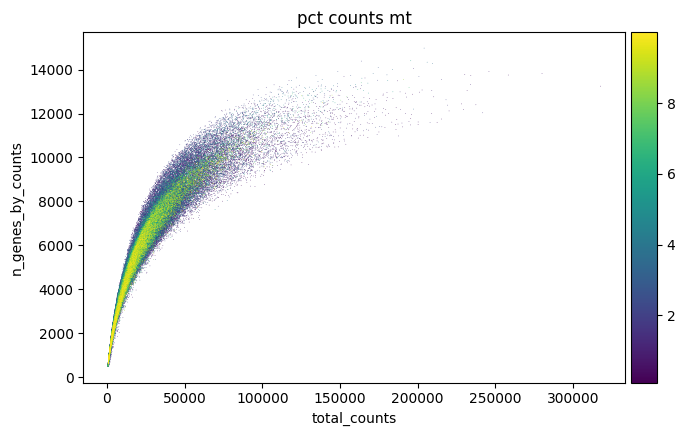

In [9]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [10]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [11]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [12]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, n_bins=100)

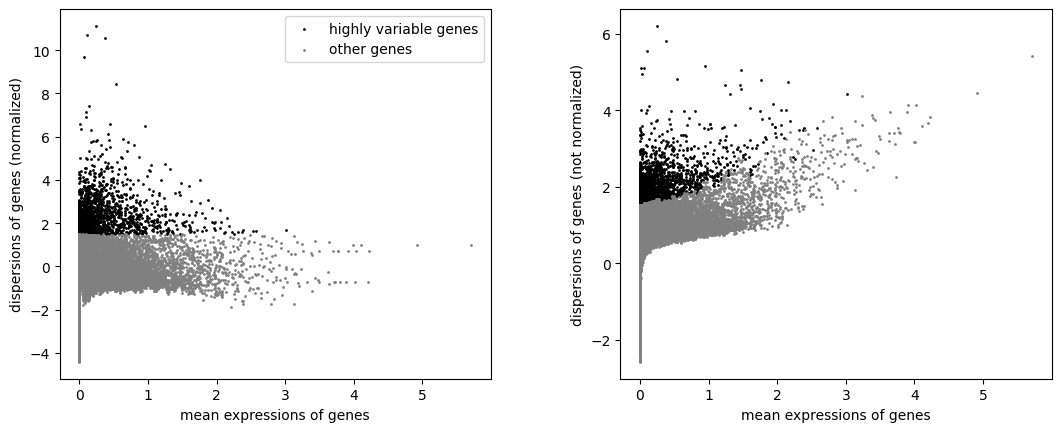

In [13]:
sc.pl.highly_variable_genes(adata)

In [14]:
sc.tl.pca(adata, n_comps=15)  # Reduce to 15 PCs

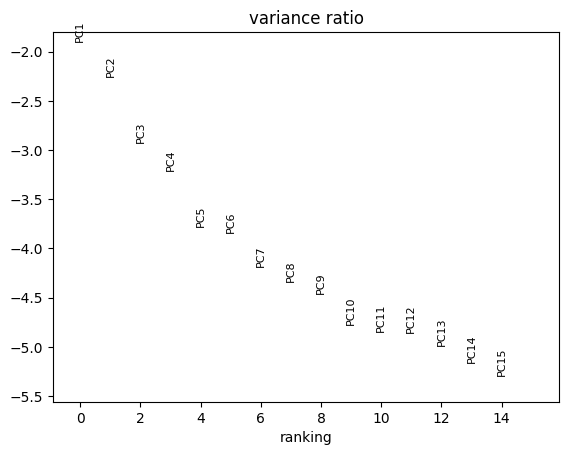

In [15]:
sc.pl.pca_variance_ratio(adata, n_pcs=15, log=True)

In [16]:
sc.pp.neighbors(adata)

In [17]:
sc.tl.umap(adata)

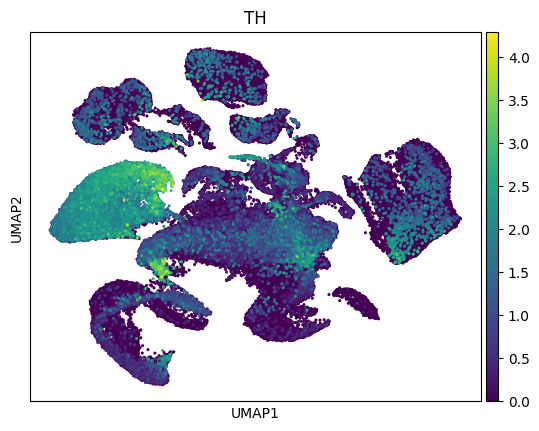

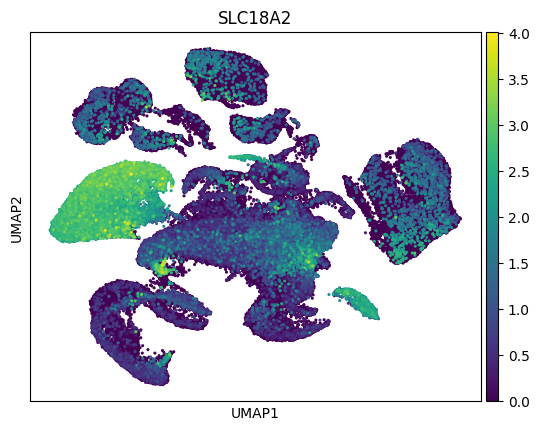

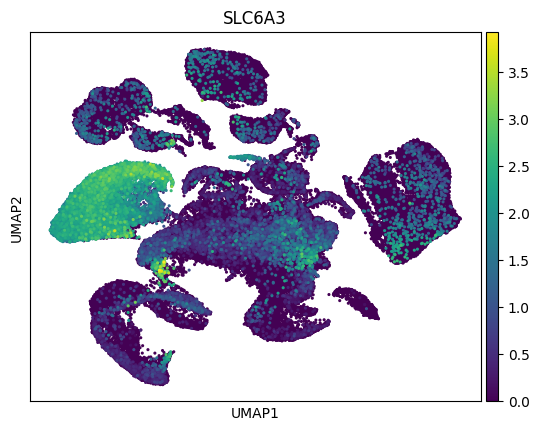

In [18]:
sc.pl.umap(adata, color="TH", cmap="viridis", size=20)
sc.pl.umap(adata, color="SLC18A2", cmap="viridis", size=20)
sc.pl.umap(adata, color="SLC6A3", cmap="viridis", size=20)

In [19]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 0.1)

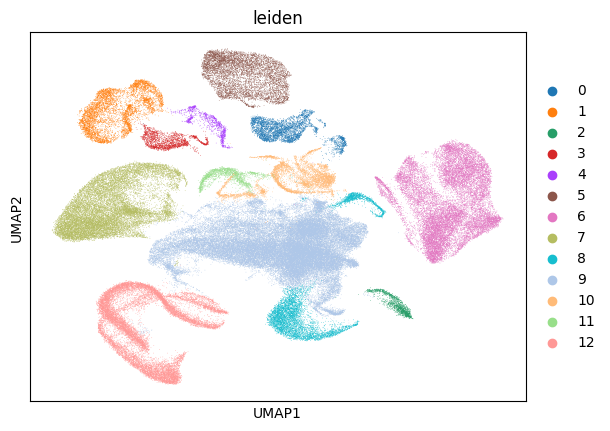

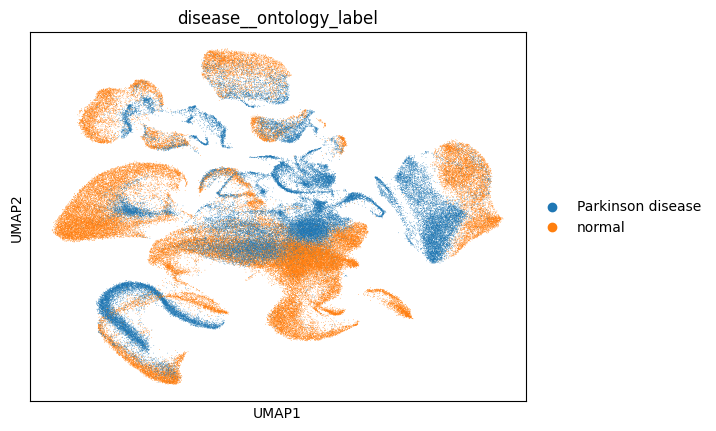

In [20]:
sc.pl.umap(adata, color=["leiden"])
sc.pl.umap(adata, color=["disease__ontology_label"])

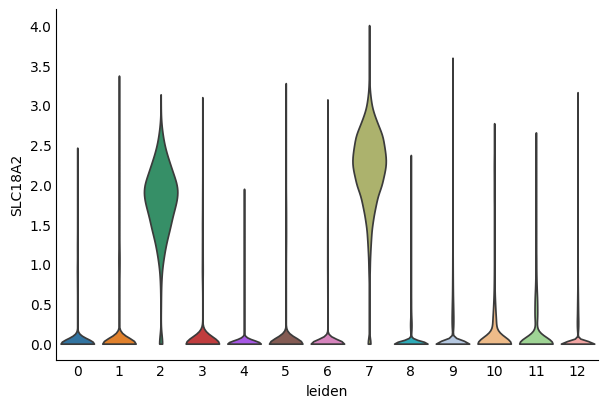

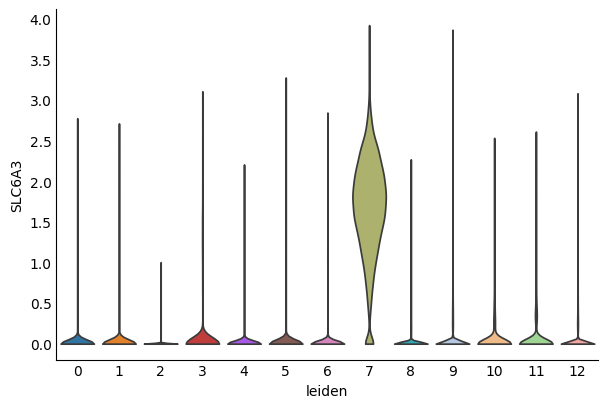

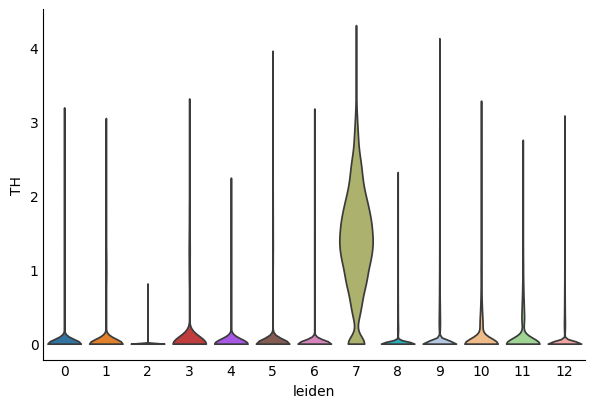

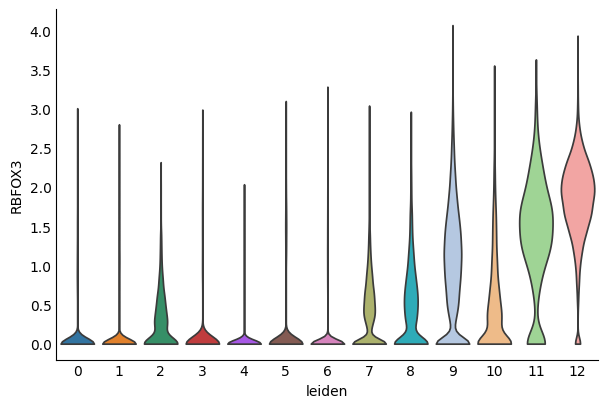

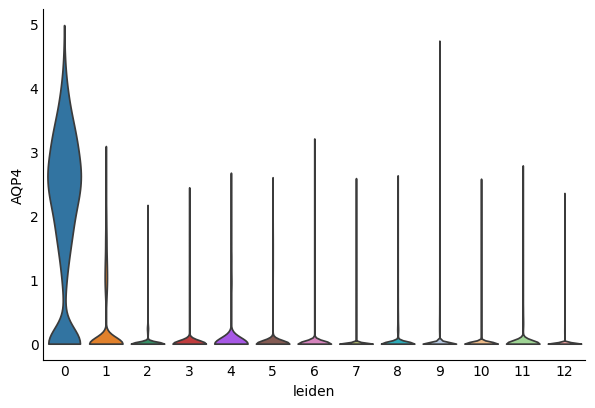

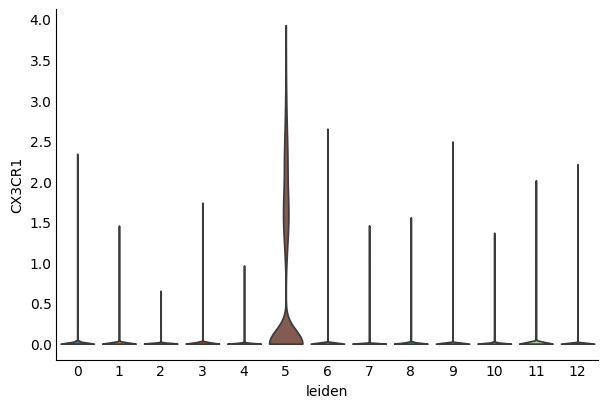

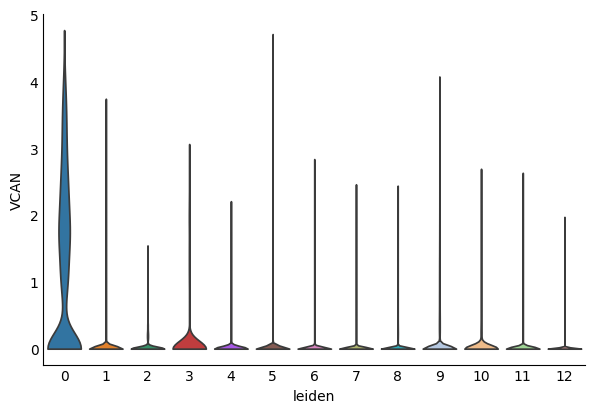

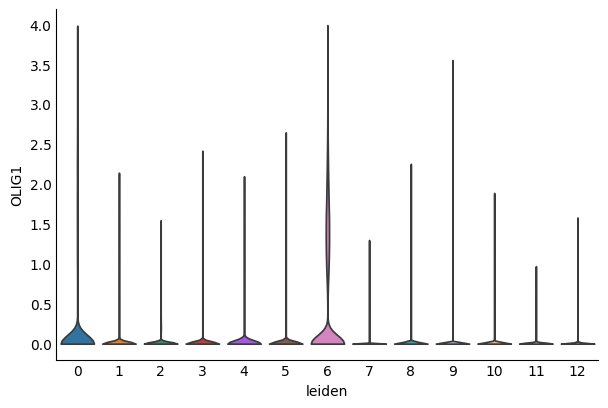

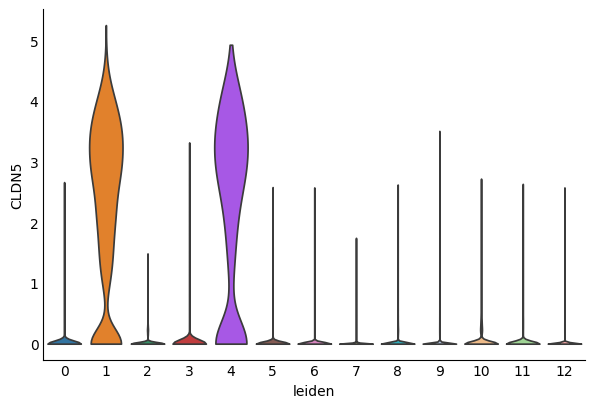

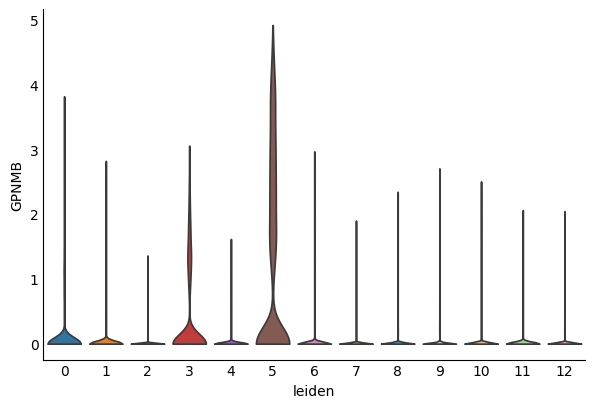

In [21]:
import matplotlib.pyplot as plt
import scanpy as sc

# List of marker genes (replace with your genes of interest)
marker_genes = ["SLC18A2", "SLC6A3", "TH", "RBFOX3","AQP4", "CX3CR1", "VCAN", "OLIG1", "CLDN5","GPNMB"]

# groupby_order = ['2', '8', '1','7','9','10','11','12','5','6','0','3']

# Create individual violin plots for each gene
for i, gene in enumerate(marker_genes):
    # Create the plot for the current gene and store the axes object
    ax = sc.pl.violin(adata,
                      keys=gene,                    # Gene of interest
                      groupby="leiden",              # Grouping by clusters
                      stripplot=False,               # Disable stripplot (no points)
                      jitter=0.4,                    # Adjust jitter for stripplot
                      size=10,                       # Adjust plot size (reduce size to halve the height)
                      # order=groupby_order,           # Sets the order of the clusters
                      show=False)                    # Avoid immediate display

    # Remove the top and right spines (bounding box lines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Optionally, remove ticks from the top and right side
    ax.tick_params(axis='both', which='both', length=0)  # Remove ticks from top and right


In [22]:
adata.obs['disease__ontology_label'].value_counts()

,count
disease__ontology_label,
normal,80643
Parkinson disease,53314


In [ ]:

# saving the adata file for another notebook

import pickle

file_path = "/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_train_pre_tokenization.pkl"

# Save
with open(file_path, 'wb') as f:
    pickle.dump(adata, f)

In [23]:
# identify cluster with highest tyrosine hydroxylase profile

def get_top_cluster_by_gene_expression(adata, gene_name, cluster_key="leiden"):
    # Handle sparse matrix if needed
    gene_expr = adata[:, gene_name].X
    if hasattr(gene_expr, "toarray"):
        gene_expr = gene_expr.toarray().flatten()
    else:
        gene_expr = gene_expr.flatten()

    # Create a DataFrame for aggregation
    df = pd.DataFrame({
        "expression": gene_expr,
        "cluster": adata.obs[cluster_key].values
    })

    # Group by cluster and compute mean expression
    mean_expr_by_cluster = df.groupby("cluster")["expression"].mean()

    # Find cluster with highest mean expression
    top_cluster = mean_expr_by_cluster.idxmax()
    top_value = mean_expr_by_cluster.max()

    print(f"Cluster with highest {gene_name} expression: {top_cluster} (mean expression = {top_value:.2f})")
    return top_cluster, top_value

top_cluster, top_value = get_top_cluster_by_gene_expression(adata, gene_name="TH")

print(top_cluster)

Cluster with highest TH expression: 7 (mean expression = 1.38)
7


<ipython-input-23-c0589d46b019>:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_expr_by_cluster = df.groupby("cluster")["expression"].mean()


In [24]:
dopamine_subset = adata[adata.obs["leiden"] == top_cluster].copy()
dopamine_subset.obs['disease__ontology_label'].value_counts()

,count
disease__ontology_label,
normal,14879
Parkinson disease,2215


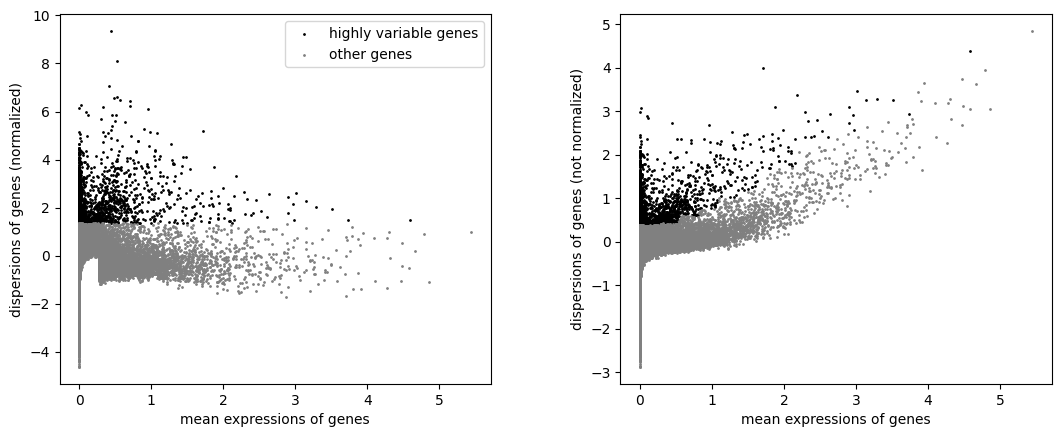

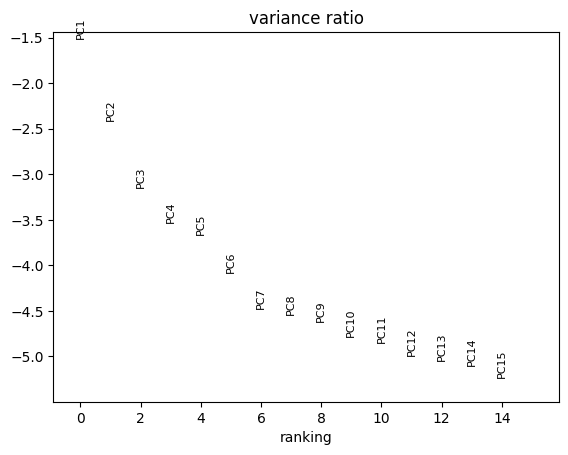

In [25]:

sc.pp.highly_variable_genes(dopamine_subset, n_top_genes=2000)
sc.pl.highly_variable_genes(dopamine_subset)
sc.tl.pca(dopamine_subset, n_comps=15)  # Reduce to 15 PCs
sc.pl.pca_variance_ratio(dopamine_subset, n_pcs=15, log=True)
sc.pp.neighbors(dopamine_subset)
sc.tl.umap(dopamine_subset)

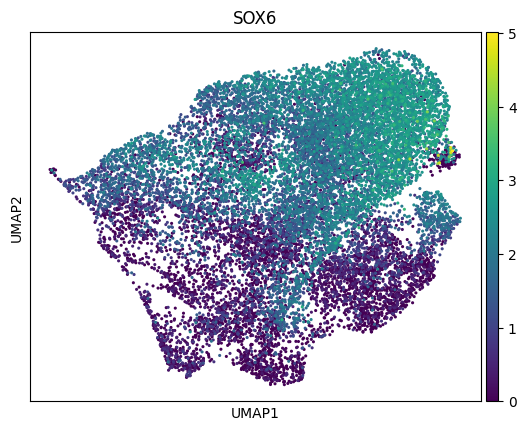

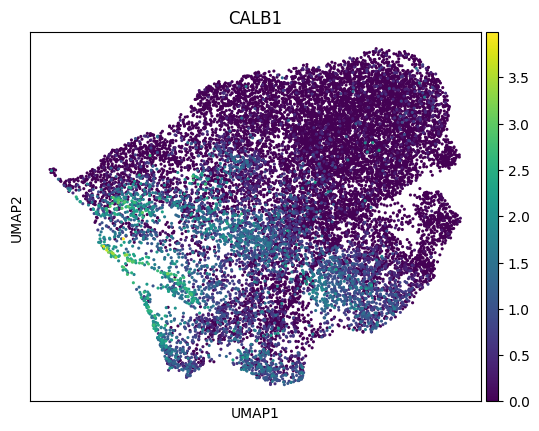

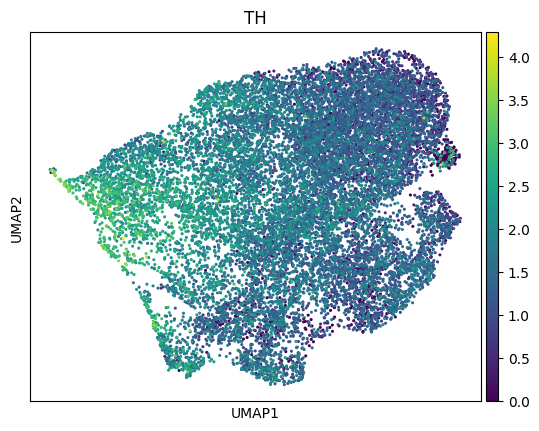

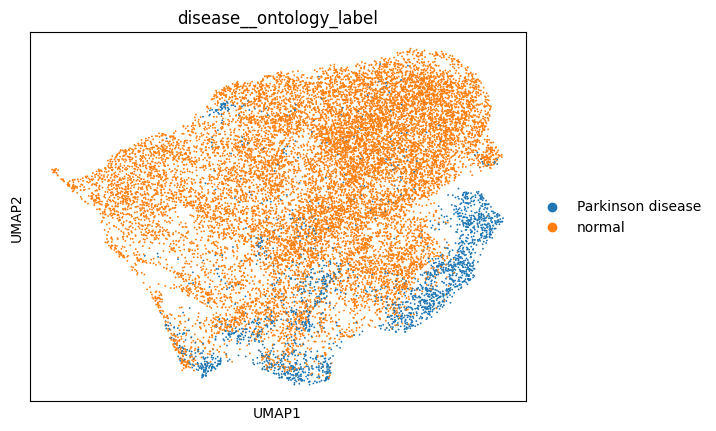

In [26]:
sc.pl.umap(dopamine_subset, color="SOX6", cmap="viridis", size=20)
sc.pl.umap(dopamine_subset, color="CALB1", cmap="viridis", size=20)
sc.pl.umap(dopamine_subset, color="TH", cmap="viridis", size=20)
sc.pl.umap(dopamine_subset, color=["disease__ontology_label"])

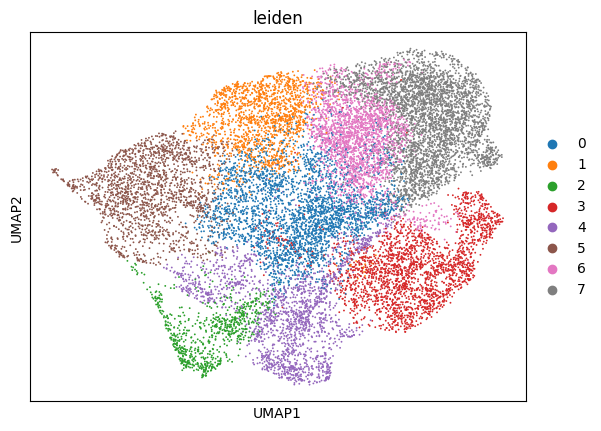

In [27]:
sc.tl.leiden(dopamine_subset, flavor="igraph", n_iterations=2, resolution = 0.3)
sc.pl.umap(dopamine_subset, color=["leiden"])

<ipython-input-28-cf2045ab0b4b>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_expression = dopamine_subset.to_df()[gene].groupby(dopamine_subset.obs[groupby]).mean()


Sorted cluster order: ['7', '6', '1', '0', '5', '4', '3', '2']


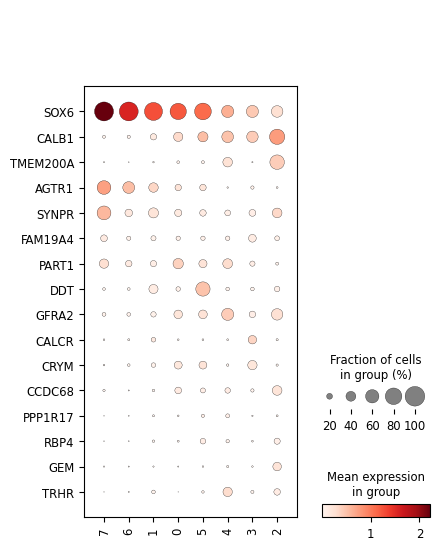

In [28]:
gene = "SOX6"  # Replace with your gene of interest
groupby = "leiden"  # Your clustering column

# Compute mean expression of the gene per cluster
mean_expression = dopamine_subset.to_df()[gene].groupby(dopamine_subset.obs[groupby]).mean()

# Sort clusters based on the expression of the gene
sorted_clusters = mean_expression.sort_values(ascending=False).index.tolist()
print("Sorted cluster order:", sorted_clusters)


# List of genes to visualize
genes = ["SOX6", "CALB1", "TMEM200A", "AGTR1", "SYNPR", "FAM19A4", "PART1", "DDT", "GFRA2", "CALCR", "CRYM", "CCDC68", "PPP1R17", "RBP4", "GEM", "TRHR"]  # Replace with your genes of interest

# Create the dot plot
sc.pl.dotplot(dopamine_subset, var_names=genes, swap_axes = True, groupby=groupby, categories_order=sorted_clusters)

In [29]:
#some of the metadata columns have mixed data types, they are converted to string to enable saving in the h5ad format
dopamine_subset.obs = dopamine_subset.obs.applymap(str)

<ipython-input-29-e2ea89561704>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dopamine_subset.obs = dopamine_subset.obs.applymap(str)


In [30]:
#create a dictionary for adding ensembl_gene_id which the nomenclature used by geneformer
#may need to be executed multiple times due to issues with biomart

!pip install pybiomart

import scanpy as sc
import pybiomart

annot = sc.queries.biomart_annotations(
    "hsapiens",
    ["ensembl_gene_id", "hgnc_symbol"],
)

gene_mapping = annot.set_index("hgnc_symbol")["ensembl_gene_id"].to_dict()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 5.2 MB/s eta 0:00:00


In [31]:
gene_symbols = dopamine_subset.var_names

# Set Ensembl IDs for corresponding gene symbols
dopamine_subset.var["ensembl_id"] = [gene_mapping.get(gene, gene) for gene in gene_symbols]

# Optionally, store the original gene symbols in adata.var
dopamine_subset.var["original_gene_symbols"] = gene_symbols

In [32]:
# additional formattings for tokenization

dopamine_subset.obs.rename(columns={"disease__ontology_label": "disease_state"}, inplace=True)
dopamine_subset.obs.rename(columns={"total_counts": "n_counts"}, inplace=True)

# generate numeric representation of disease state
mapping = {"normal": 0, "Parkinson disease": 1}  # Adjust based on actual values
dopamine_subset.obs["disease_state_numeric"] = dopamine_subset.obs["disease_state"].map(mapping)

#reassign raw counts to the adata.x slot
dopamine_subset.X = dopamine_subset.layers['counts']

# also neccesary to change some of the category labels to numeric, so the they work with the tokenizer
dopamine_subset.obs['n_counts'] = pd.to_numeric(dopamine_subset.obs['n_counts'], errors='coerce')

#removes the space from parkinson's disease
dopamine_subset.obs['disease_state'] = dopamine_subset.obs['disease_state'].str.replace('Parkinson disease', 'Parkinson_disease')

# this should now be formatted correctly for geneformer
dopamine_subset.write('/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_pre_tokenization.h5ad')

In [33]:
import os

file_path = "/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_pre_tokenization.h5ad"

if os.path.exists(file_path):
    print("File exists!")
else:
    print("File was not saved.")

File exists!


In [ ]:
## Subsetting based on donor id to reduce the the impact of overfitting the models based on donor variance within samples

In [34]:
dopamine_subset.obs['donor_id'].unique()

['3482', '3346', '3873', '5610', '3322', ..., '2142', '4568', '6173', '1963', '3298']
Length: 14
Categories (14, object): ['1963', '2142', '3298', '3322', ..., '4568', '4956', '5610', '6173']

In [35]:
normal_subset = dopamine_subset[dopamine_subset.obs['disease_state'] == 'normal'].copy()
print(normal_subset.shape[0])
normal_subset.obs['donor_id'].value_counts()

14879


,count
donor_id,
4956,6473
3345,2905
3482,1612
6173,1485
3346,1422
5610,539
3322,387
3298,56


In [36]:
disease_subset = dopamine_subset[dopamine_subset.obs['disease_state'] != 'normal'].copy()
print(disease_subset.shape[0])
disease_subset.obs['donor_id'].value_counts()

2215


,count
donor_id,
4560,1909
3873,193
3887,76
2142,19
1963,12
4568,6


In [38]:
# donor_list = ['3322', '3482', '3873','3887']

donor_list = ['3345', '3322', '3873','3887']


disease_subset_test = dopamine_subset[dopamine_subset.obs['donor_id'].isin(donor_list)].copy()
print(disease_subset_test.shape[0])

disease_subset_train = dopamine_subset[~dopamine_subset.obs['donor_id'].isin(donor_list)].copy()
print(disease_subset_train.shape[0])


# Create both folders if they don't exist
os.makedirs('/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_train', exist_ok=True)
os.makedirs('/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_test', exist_ok=True)

# saving each of these for tokenization
disease_subset_test.write('/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_test/dopamine_subset_test_pre_tokenization.h5ad')

disease_subset_train.write('/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_train/dopamine_subset_train_pre_tokenization.h5ad')

3561
13533


In [42]:
file_path = "/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_test/dopamine_subset_test_pre_tokenization.h5ad"

if os.path.exists(file_path):
    print("File exists!")
else:
    print("File was not saved.")

File exists!


In [43]:
file_path = "/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_train/dopamine_subset_train_pre_tokenization.h5ad"

if os.path.exists(file_path):
    print("File exists!")
else:
    print("File was not saved.")

File exists!


In [41]:
!find /content -name "*.h5ad"

/content/drive/MyDrive/HODD/kamath_adata_file.h5ad
/content/drive/MyDrive/HODD/kamath_adata_file_procssed.h5ad
/content/drive/MyDrive/HODD/kamath_dopmaine_subset.h5ad
/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_train/dopamine_subset_train_pre_tokenization.h5ad
/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_test/dopamine_subset_test_pre_tokenization.h5ad
/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/presubset_dop_subset_adata.h5ad
/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_pre_tokenization.h5ad


In [ ]:
dopamine_subset.obs["disease_state_numeric"]

,disease_state_numeric
pPDsHSrSNxi3482d200429PosB_CAATGACTCTCTGCCA-1,0
pPDsHSrSNxi3482d200429PosB_CTCTGGTCAGCTACTA-1,0
pPDsHSrSNxi3482d200429PosB_ACTACGAGTATGCAAA-1,0
pPDsHSrSNxi3482d200429PosB_GACGCTGAGCCGTAAG-1,0
pPDsHSrSNxi3482d200429PosB_ATACTTCTCCAGCTCT-1,0
...,...
pPDsHSrSNxi3298d200429PosB_CATACTTGTCTGATCA-1,0
pPDsHSrSNxi3298d200429PosB_TTTGTTGTCCTTGAAG-1,0
pPDsHSrSNxi3298d200429PosB_ACACTGACACTAGAGG-1,0
pPDsHSrSNxi3298d200429PosB_CAACAACAGCTCGAAG-1,0


In [37]:
dopamine_subset.obs["disease_state"]

,disease_state
pPDsHSrSNxi3482d200429PosB_CAATGACTCTCTGCCA-1,normal
pPDsHSrSNxi3482d200429PosB_CTCTGGTCAGCTACTA-1,normal
pPDsHSrSNxi3482d200429PosB_ACTACGAGTATGCAAA-1,normal
pPDsHSrSNxi3482d200429PosB_GACGCTGAGCCGTAAG-1,normal
pPDsHSrSNxi3482d200429PosB_ATACTTCTCCAGCTCT-1,normal
...,...
pPDsHSrSNxi3298d200429PosB_CATACTTGTCTGATCA-1,normal
pPDsHSrSNxi3298d200429PosB_TTTGTTGTCCTTGAAG-1,normal
pPDsHSrSNxi3298d200429PosB_ACACTGACACTAGAGG-1,normal
pPDsHSrSNxi3298d200429PosB_CAACAACAGCTCGAAG-1,normal


In [ ]:
dopamine_subset.obs

,libname,biosample_id,donor_id,species,species__ontology_label,disease,disease_state,organ,organ__ontology_label,library_preparation_protocol,...,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,leiden,disease_state_numeric
pPDsHSrSNxi3482d200429PosB_CAATGACTCTCTGCCA-1,pPDsHSrSNxi3482d200429PosB,pPDsHSrSNxi3482d200429PosB,3482,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0001965,substantia nigra pars compacta,EFO_0009901,...,8.407824654360873,2.2307294052052016,834,6.727431724850855,0.41518150500806467,11,2.4849066497880004,0.0054760150540632034,0,0
pPDsHSrSNxi3482d200429PosB_CTCTGGTCAGCTACTA-1,pPDsHSrSNxi3482d200429PosB,pPDsHSrSNxi3482d200429PosB,3482,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0001965,substantia nigra pars compacta,EFO_0009901,...,8.70267641154777,4.080165972853133,344,5.84354441703136,0.2332298262980189,13,2.6390573296152584,0.008813917854285598,4,0
pPDsHSrSNxi3482d200429PosB_ACTACGAGTATGCAAA-1,pPDsHSrSNxi3482d200429PosB,pPDsHSrSNxi3482d200429PosB,3482,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0001965,substantia nigra pars compacta,EFO_0009901,...,5.556828061699537,1.3800481412142285,67,4.219507705176107,0.3583845948114469,3,1.3862943611198906,0.016047071409467772,6,0
pPDsHSrSNxi3482d200429PosB_GACGCTGAGCCGTAAG-1,pPDsHSrSNxi3482d200429PosB,pPDsHSrSNxi3482d200429PosB,3482,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0001965,substantia nigra pars compacta,EFO_0009901,...,5.988961416889864,6.512845688103421,54,4.007333185232471,0.8836524300441826,0,0.0,0.0,5,0
pPDsHSrSNxi3482d200429PosB_ATACTTCTCCAGCTCT-1,pPDsHSrSNxi3482d200429PosB,pPDsHSrSNxi3482d200429PosB,3482,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0001965,substantia nigra pars compacta,EFO_0009901,...,4.852030263919617,2.320058458165875,67,4.219507705176107,1.2239678480087688,3,1.3862943611198906,0.05480453050785532,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pPDsHSrSNxi3298d200429PosB_CATACTTGTCTGATCA-1,pPDsHSrSNxi3298d200429PosB,pPDsHSrSNxi3298d200429PosB,3298,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0001965,substantia nigra pars compacta,EFO_0009901,...,6.882437470997847,8.736993182633658,11,2.4849066497880004,0.0986724076067456,0,0.0,0.0,6,0
pPDsHSrSNxi3298d200429PosB_TTTGTTGTCCTTGAAG-1,pPDsHSrSNxi3298d200429PosB,pPDsHSrSNxi3298d200429PosB,3298,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0001965,substantia nigra pars compacta,EFO_0009901,...,6.447305862541213,6.032749209997127,9,2.302585092994046,0.08618213157138753,0,0.0,0.0,6,0
pPDsHSrSNxi3298d200429PosB_ACACTGACACTAGAGG-1,pPDsHSrSNxi3298d200429PosB,pPDsHSrSNxi3298d200429PosB,3298,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0001965,substantia nigra pars compacta,EFO_0009901,...,6.717804695023691,8.553380967174071,12,2.5649493574615367,0.12426219322771047,0,0.0,0.0,6,0
pPDsHSrSNxi3298d200429PosB_CAACAACAGCTCGAAG-1,pPDsHSrSNxi3298d200429PosB,pPDsHSrSNxi3298d200429PosB,3298,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0001965,substantia nigra pars compacta,EFO_0009901,...,6.659293919683638,8.298710983274741,12,2.5649493574615367,0.1278363694471077,0,0.0,0.0,6,0
